# Profiling escape of Perth/2009 H3 HA from human monoclonal antibodies

This project is in collaboration with Seth Zost and Scott Hensley.
The experiments and analysis below were performed by Juhye Lee and Jesse Bloom.
The analysis uses the [dms_tools2](https://jbloomlab.github.io/dms_tools2/) software package.

## Overview

I performed mutational antigenic profiling of monoclonal antibodies that target seasonal influenza H3 hemagglutinin. These monoclonal antibodies were isolated from humans seven days post-vaccination with the A/Victoria/210/2009 (H3N2) strain. 

I used mutant virus libraries of the A/Perth/16/2009 (H3N2) HA using the procedure described in [Lee et al (2018)](https://www.biorxiv.org/content/early/2018/04/09/298364). One of the mutant virus libraries (denoted as _library 4_ below) was generated by reverse genetics and passaged in MDCK-SIAT1-TMPRSS2 cells. The analysis of the reverse-genetics library is in the [DMS_analysis](../DMS_analysis/) subdirectory.

## Experimental summary

I selected biological replicates of the virus libraries carrying mutant HA's with different neutralizing concentrations of each monoclonal antibody. I then infected cells with the neutralized viruses, extracted RNA from the infected cells, reverse-transcribed and amplified the extracted RNA, and deep sequenced the libraries using a barcoded-subamplicon approach.

In this analysis, we examine deep sequencing data from these antibody selections and evaluate amino-acid mutations that enable escape from each of these antibodies.

# Import modules, define directories

In [2]:
import os
import glob
import math
import time
import pandas as pd
import numpy as np
import scipy
import rpy2
import rpy2.robjects
import matplotlib as mpl
import  matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import dms_tools2
import dms_tools2.plot
import dms_tools2.rplot
import dms_tools2.sra
import dms_tools2.diffsel
from dms_tools2.ipython_utils import showPDF
import warnings
warnings.simplefilter('ignore')
from IPython.display import display, HTML

print('Using dms_tools2 version {0}'.format(dms_tools2.__version__))

# define created directories
inputdir = './data/'
resultsdir = './results/'    
fastqdir = os.path.join(resultsdir, 'FASTQ_files/')
countsdir = os.path.join(resultsdir, 'codoncounts/')
# renumbered counts will go here
renumberedcountsdir = os.path.join(resultsdir, 'renumberedcounts')
diffseldir = os.path.join(resultsdir, 'differential_selections/')
plotsdir = os.path.join(resultsdir, 'plots/')

for d in [inputdir, resultsdir, fastqdir, 
          countsdir, renumberedcountsdir,  
          diffseldir, plotsdir]:
    os.makedirs(d, exist_ok=True)
    
# CPUs to use, should not exceed the number you request with slurm
ncpus = 4 

# do we use existing results or generate everything new?
use_existing = 'yes'

Using dms_tools2 version 2.4.10


# Overview of selection conditions and sample names

As input data, we have a CSV file ([data/samples.csv](data/samples.csv)) that defines the samples. We read this file into a `pandas` dataframe that lists the sample names with the following associated information:

1. SRA run number
2. the antibody used for selection (`none` for mock selections and WT plasmid control)
3. the concentration ($\mu$g/ml) of antibody used to neutralize the libraries
4. the fraction infectivity after neutralization, as estimated by qPCR.

Note that the `name` column shows the library replicate, antibody and concentration used for the selection experiment. L2 and L3 denote replicate 2 or replicate 3 libraries generated by using a helper virus. L4 denotes the mutant virus library generated by reverse genetics.

I also performed mock neutralization controls, named `L#mock`, where each library was mixed with Influenza Growth Media (IGM) rather than with antibody, and this inoculum was used to infect cells.

Finally, I sequenced the Perth/2009 H3-encoding `WTplasmid`, to use for error correction below. For the reverse-genetics library (library 4), the WT plasmid control is `WT-pHH-plasmid`.

In [3]:
samples = pd.read_csv('./data/samples.csv')
display(HTML(samples.to_html(index=False)))

name,run,antibody,ug/ml_Ab,libfracsurvive
L2-3C06-1ug-ml,SRR7974474,3C06,1.00,0.000067
L2-3C04-1ug-ml,SRR7974475,3C04,1.00,0.000262
L2-3C06-550ng-ml,SRR7974483,3C06,0.55,0.000100
L2-3C06-700ng-ml,SRR7974489,3C06,0.70,0.000088
L2-3C04-650ng-ml,SRR7974490,3C04,0.65,0.000331
L2mock-A,SRR7974494,none,0.00,1.000000
WTplasmid-A,SRR7974495,none,0.00,1.000000
L2-3C06-200ng-ml,SRR7974506,3C06,0.20,0.116800
L2-3C04-200ng-ml,SRR7974505,3C04,0.20,0.110100
L2mock-B,SRR7974508,none,0.00,1.000000


# Download `FASTQ` files from the SRA

All of the FASTQ files are on the Sequence Read Archive (SRA) under the run numbers listed in the `samples` dataframe defined above.
To download these files, we just pass that dataframe to the [dms_tools2.sra.fastqFromSRA function](https://jbloomlab.github.io/dms_tools2/dms_tools2.sra.html#dms_tools2.sra.fastqFromSRA).
Note that this requires the `fastq-dump` and `aspera` programs to be installed on the computer you are using at the specified paths.

In [4]:
print('Downloading FASTQ files from the SRA...')
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            ),
        overwrite={'no':True, 'yes':False}[use_existing],
        )
print('Completed download of FASTQ files from the SRA')

Completed download of FASTQ files from the SRA


# Align the deep sequencing data and count mutations

We used a barcoded-subamplicon sequencing approach to prep and deep sequence the libraries to high accuracy, as described in [Doud, Hensley, and Bloom (2017)](http://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006271). 
We will now align the deep sequencing reads using [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html).

It is also worth noting that we have specified trimming parameters for Read 1 and Read 2. 
The trimming was designed to clip off the worst-quality regions of each read for each sample.

We align to the reference sequence in [data/Perth09_HA_reference.fa](data/Perth09_HA_reference.fa).

In [5]:
# file containing wildtype WSN HA sequence
refseq = './data/Perth09_HA_reference.fa'

# define subamplicon alignment specifications
alignspecs = ' '.join(['1,285,38,40', '286,567,33,34', '568,852,34,30', 
                       '853,1137,34,31', '1138,1422,36,29', '1423,1701,39,44'])

# write batch file for dms2_batch_bcsubamp
countsbatchfile = os.path.join(countsdir, 'batch.csv')
samples[['name', 'R1']].to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 --R2trim 165 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing}  
print('Completed dms2_batch_bcsubamp.')


Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


The summary plots from [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html) will have a prefix since it is what was passed as `--summaryprefix`. We now define this prefix.

In [6]:
countsplotprefix = os.path.join(countsdir, 'summary')

This plot shows the number of reads per barcode. Note that I bottlenecked to more barcodes for `L2mock-A`, `L3mock` and `L4mock`, resulting in more reads for these samples.

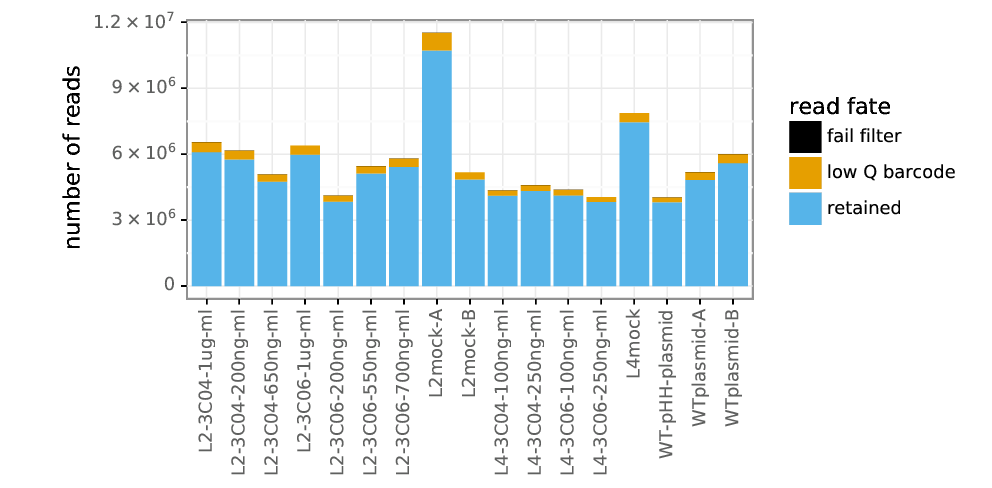

In [7]:
showPDF(countsplotprefix + '_readstats.pdf')

This next plot shows the number of reads per barcode.
Overall read depth for all of the samples looks very good. 
L3-3C06-200ng-ml may be somewhat undersequenced, while some of the L2-selected samples, especially in the top row of the plot below, look a bit oversequenced.

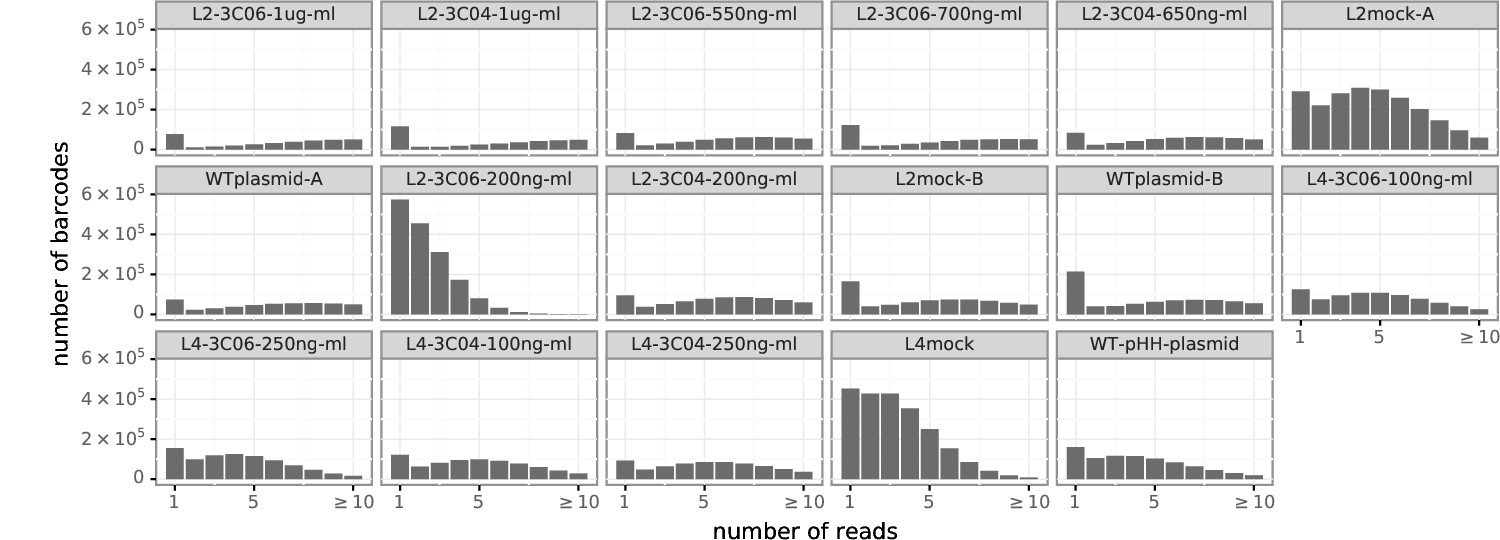

In [8]:
showPDF(countsplotprefix + '_readsperbc.pdf')

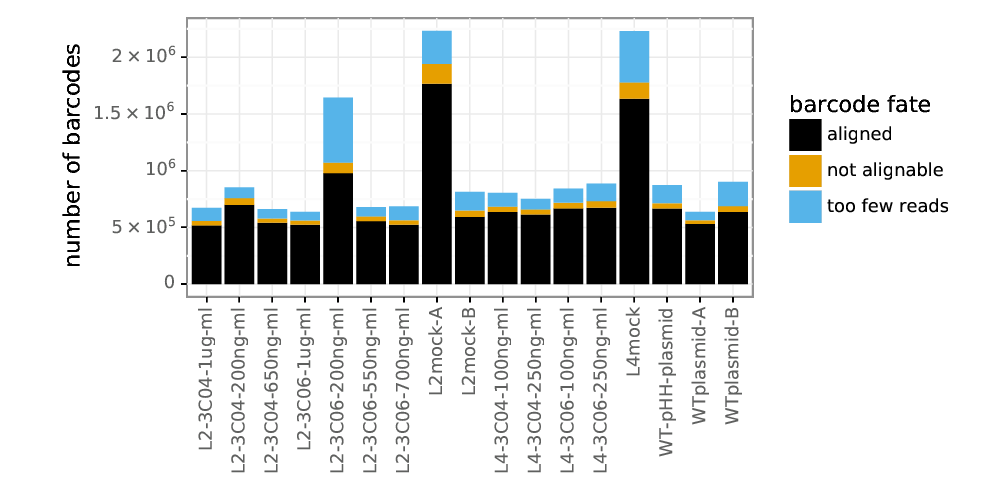

In [9]:
showPDF(countsplotprefix + '_bcstats.pdf')

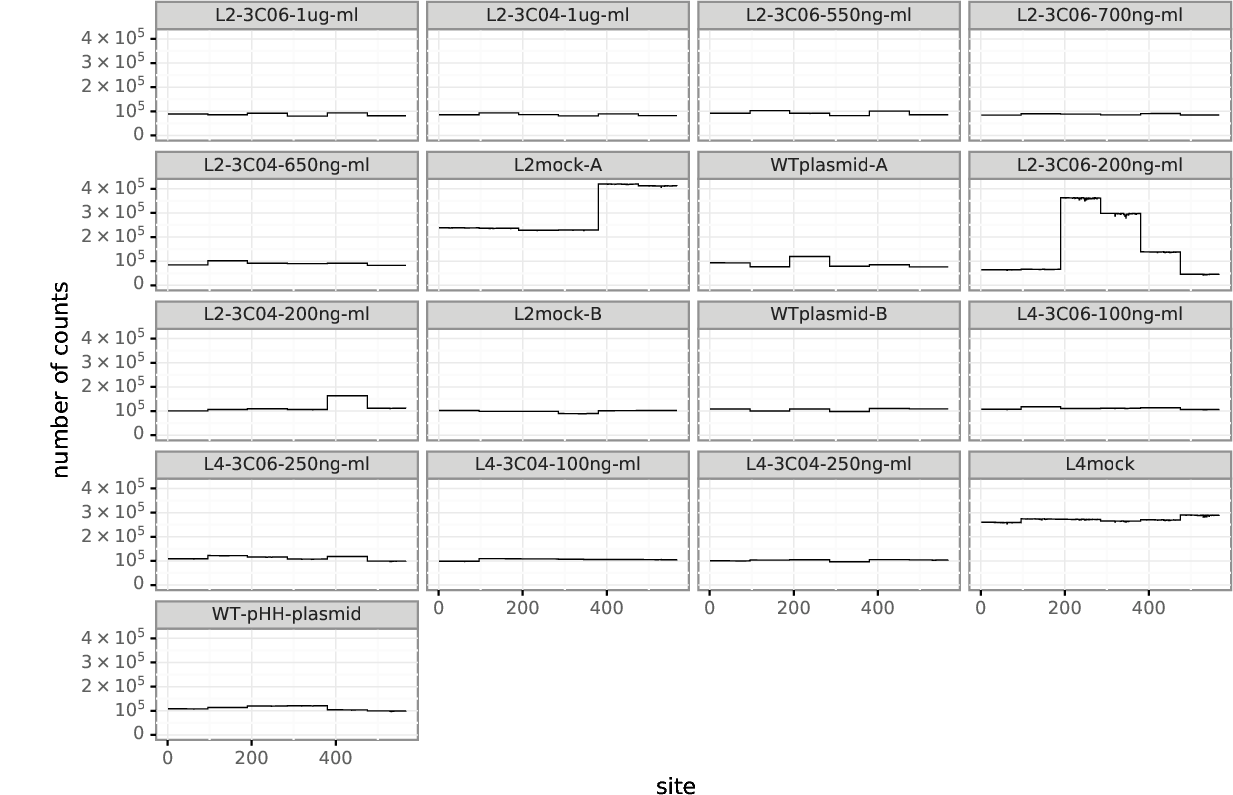

In [10]:
showPDF(countsplotprefix + '_depth.pdf')

The read depth looks pretty even across the gene for most of the samples

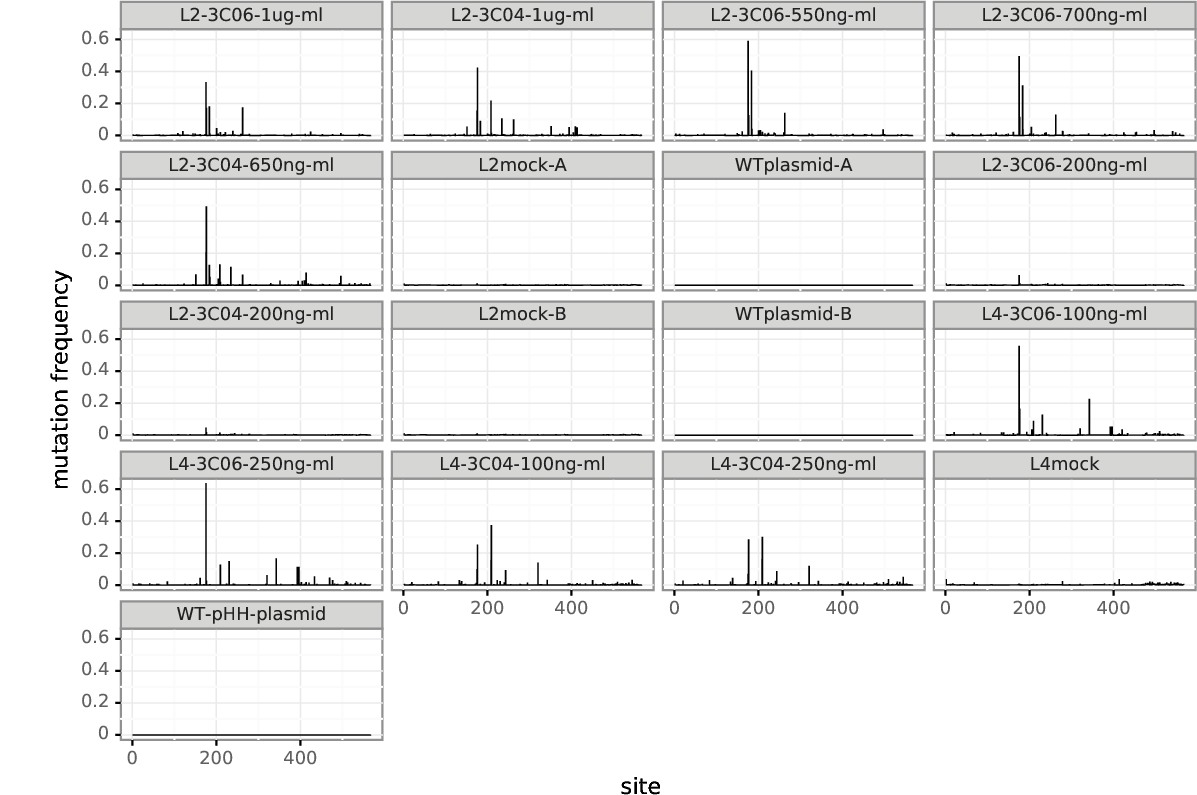

In [11]:
showPDF(countsplotprefix + '_mutfreq.pdf')

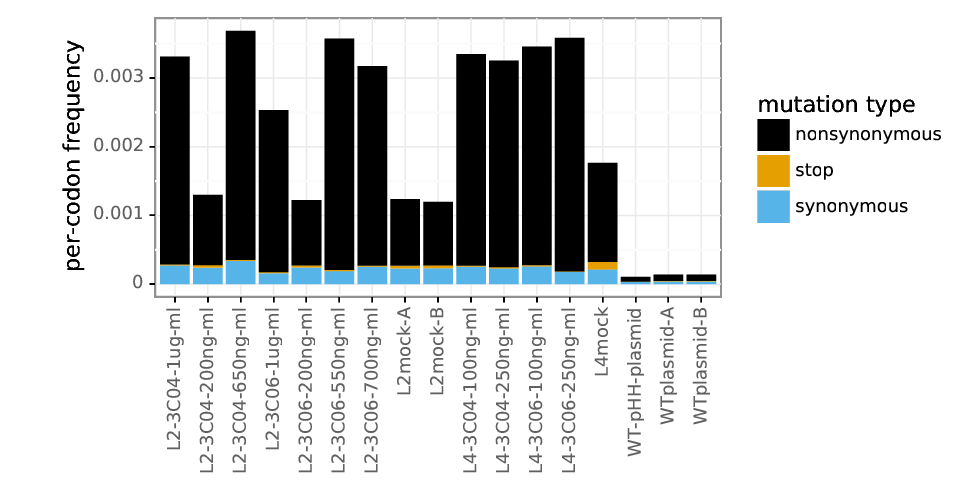

In [12]:
showPDF(countsplotprefix + '_codonmuttypes.pdf')

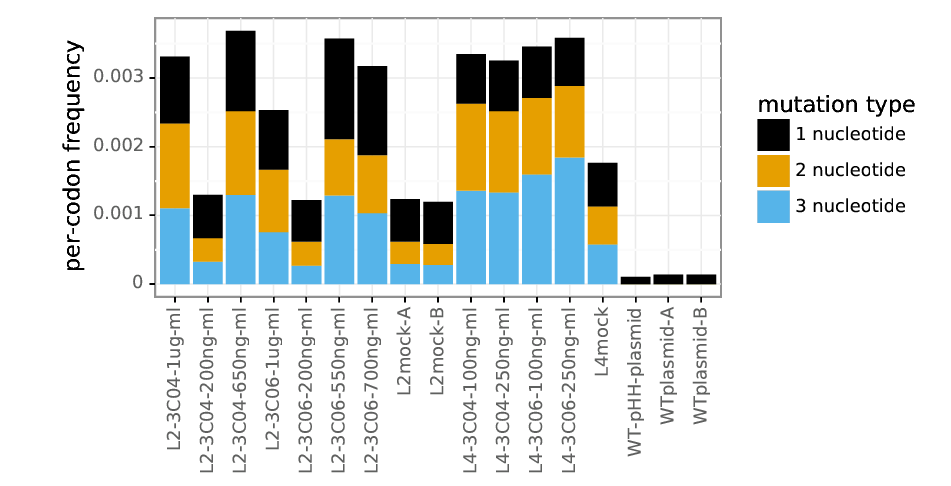

In [13]:
showPDF(countsplotprefix + '_codonntchanges.pdf')

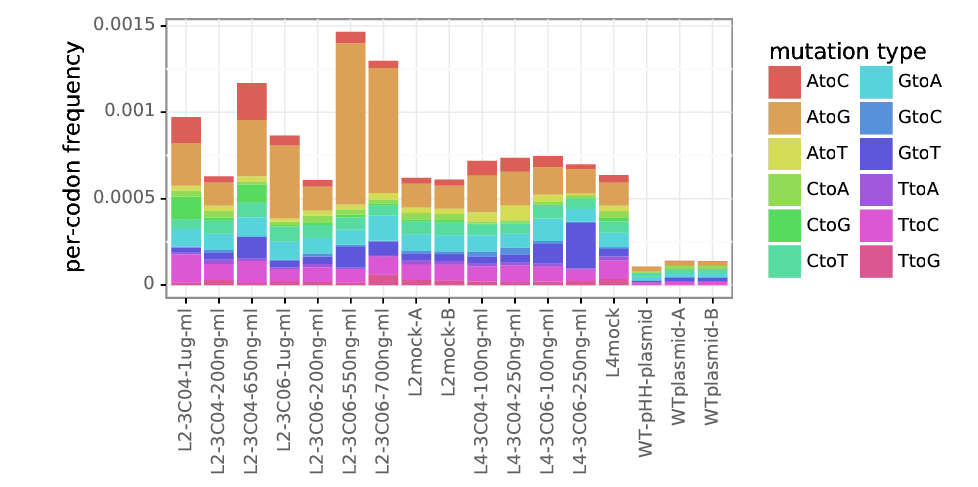

In [14]:
showPDF(countsplotprefix + '_singlentchanges.pdf')

Only the `L4-3C06-250ng-ml` sample appears to show signs of oxidative damage (enrichment of `G to T` and `C to A` mutations), with more `G to T` mutations than `C to A` mutations. The other samples do not display much oxidative damage.

## Renumber codon counts to H3 numbering

We will now **renumber the codon counts** from sequential (1, 2, ... starting from the initial Met) to H3 numbering. The signal peptide is numbered with negative values, and the HA1 and HA2 subunits are numbered separately. This numbering scheme is based on an alignment to a PDB structure for an H3 HA 4HMG. We will use:

* The [./data/H3renumbering_scheme.csv](./data/H3renumbering_scheme.csv) file to convert the sequential numbers for the Perth/2009 H3 HA into the H3 numbering scheme
* The [dms_tools2.utils.renumberSites](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.renumberSites) function to renumber the codon counts files

The renumbered files will be created in a new `renumberedcounts` directory and will possess the same names as the original codon counts files created from dms2_batch_bcsubamp above.

In [15]:
renumberfile = './data/H3renumbering_scheme.csv'

# counts files to renumber
countsfiles = glob.glob('{0}/*codoncounts.csv'.format(countsdir))

dms_tools2.utils.renumberSites(renumberfile, countsfiles, missing='drop', 
        outdir=renumberedcountsdir)

## Profiling escape from different antibodies

Now we will use [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/diffsel.html) to profile escape from the different antibodies. Due to technical difficulties in accurately estimating the overall library fraction survive by qPCR, we will use differential selection here instead of `fracsurvive`.

We first define a `diffselbatch` dataframe that we write to CSV format to use as input to [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/diffsel.html).

In [21]:
diffselbatch = pd.DataFrame.from_records([ 
         # 3C06
         ('3C06', 'replicate-2a', 'L2-3C06-200ng-ml', 'L2mock-B', 'WTplasmid-B'),
         ('3C06', 'replicate-2b', 'L2-3C06-550ng-ml', 'L2mock-A', 'WTplasmid-A'),
         ('3C06', 'replicate-2c', 'L2-3C06-700ng-ml', 'L2mock-A', 'WTplasmid-A'),  
         ('3C06', 'replicate-2d', 'L2-3C06-1ug-ml', 'L2mock-A', 'WTplasmid-A'), 
         ('3C06', 'replicate-4a', 'L4-3C06-100ng-ml', 'L4mock', 'WT-pHH-plasmid'), 
         ('3C06', 'replicate-4b', 'L4-3C06-250ng-ml', 'L4mock', 'WT-pHH-plasmid'),
         # 3C04
         ('3C04', 'replicate-2a', 'L2-3C04-200ng-ml', 'L2mock-B', 'WTplasmid-B'),
         ('3C04', 'replicate-2b', 'L2-3C04-650ng-ml', 'L2mock-A', 'WTplasmid-A'), 
         ('3C04', 'replicate-2c', 'L2-3C04-1ug-ml', 'L2mock-A', 'WTplasmid-A'),
         ('3C04', 'replicate-4a', 'L4-3C04-100ng-ml', 'L4mock', 'WT-pHH-plasmid'),
         ('3C04', 'replicate-4b', 'L4-3C04-250ng-ml', 'L4mock', 'WT-pHH-plasmid'),
        ],       
        columns=['group', 'name', 'sel', 'mock', 'err']
        )

# make nicely formatted grouplabels (antibody names) for faceted plots
diffselbatch['grouplabel'] = (diffselbatch['group']
        .str.replace('3C06', 'antibody: 3C06')
        .str.replace('3C04', 'antibody: 3C04')
        )

# add column with antibody name, which is word item in group name
diffselbatch['antibody'] = list(map(lambda g: g.split('-')[0], diffselbatch['group']))

# display and write information
diffselbatchfile = os.path.join(diffseldir, 'batch.csv')
print("Here is the batch input that we write to the CSV file {0}:".format(diffselbatchfile))
display(HTML(diffselbatch.to_html(index=False)))
diffselbatch.to_csv(diffselbatchfile, index=False)

Here is the batch input that we write to the CSV file ./results/differential_selections/batch.csv:


group,name,sel,mock,err,grouplabel,antibody
3C06,replicate-2a,L2-3C06-200ng-ml,L2mock-B,WTplasmid-B,antibody: 3C06,3C06
3C06,replicate-2b,L2-3C06-550ng-ml,L2mock-A,WTplasmid-A,antibody: 3C06,3C06
3C06,replicate-2c,L2-3C06-700ng-ml,L2mock-A,WTplasmid-A,antibody: 3C06,3C06
3C06,replicate-2d,L2-3C06-1ug-ml,L2mock-A,WTplasmid-A,antibody: 3C06,3C06
3C06,replicate-4a,L4-3C06-100ng-ml,L4mock,WT-pHH-plasmid,antibody: 3C06,3C06
3C06,replicate-4b,L4-3C06-250ng-ml,L4mock,WT-pHH-plasmid,antibody: 3C06,3C06
3C04,replicate-2a,L2-3C04-200ng-ml,L2mock-B,WTplasmid-B,antibody: 3C04,3C04
3C04,replicate-2b,L2-3C04-650ng-ml,L2mock-A,WTplasmid-A,antibody: 3C04,3C04
3C04,replicate-2c,L2-3C04-1ug-ml,L2mock-A,WTplasmid-A,antibody: 3C04,3C04
3C04,replicate-4a,L4-3C04-100ng-ml,L4mock,WT-pHH-plasmid,antibody: 3C04,3C04


We now run `dms2_batch_diffsel` with the output written to the directory `./results/differential_selections`.

In [22]:
print ("Running dms2_batch_diffsel and writing output to {0}".format(diffseldir))
log = !dms2_batch_diffsel \
        --summaryprefix summary \
        --batchfile {diffselbatchfile} \
        --outdir {diffseldir} \
        --indir {renumberedcountsdir} \
        --use_existing {use_existing}

print ("Completed run.")

Running dms2_batch_diffsel and writing output to ./results/differential_selections/
Completed run.


In [23]:
diffselprefix = os.path.join(diffseldir, 'summary_')

First, we look at the correlations among the replicates for each antibody. We do this looking at the **positive site differential selection** at each site. These plots have the suffix `positivesitediffselcorr.pdf`. 

As seen below, the replicates are generally reasonably correlated, with correlations being higher between replicates _within_ a library than for replicates _across_ libraries.


Replicate correlations for 3C06


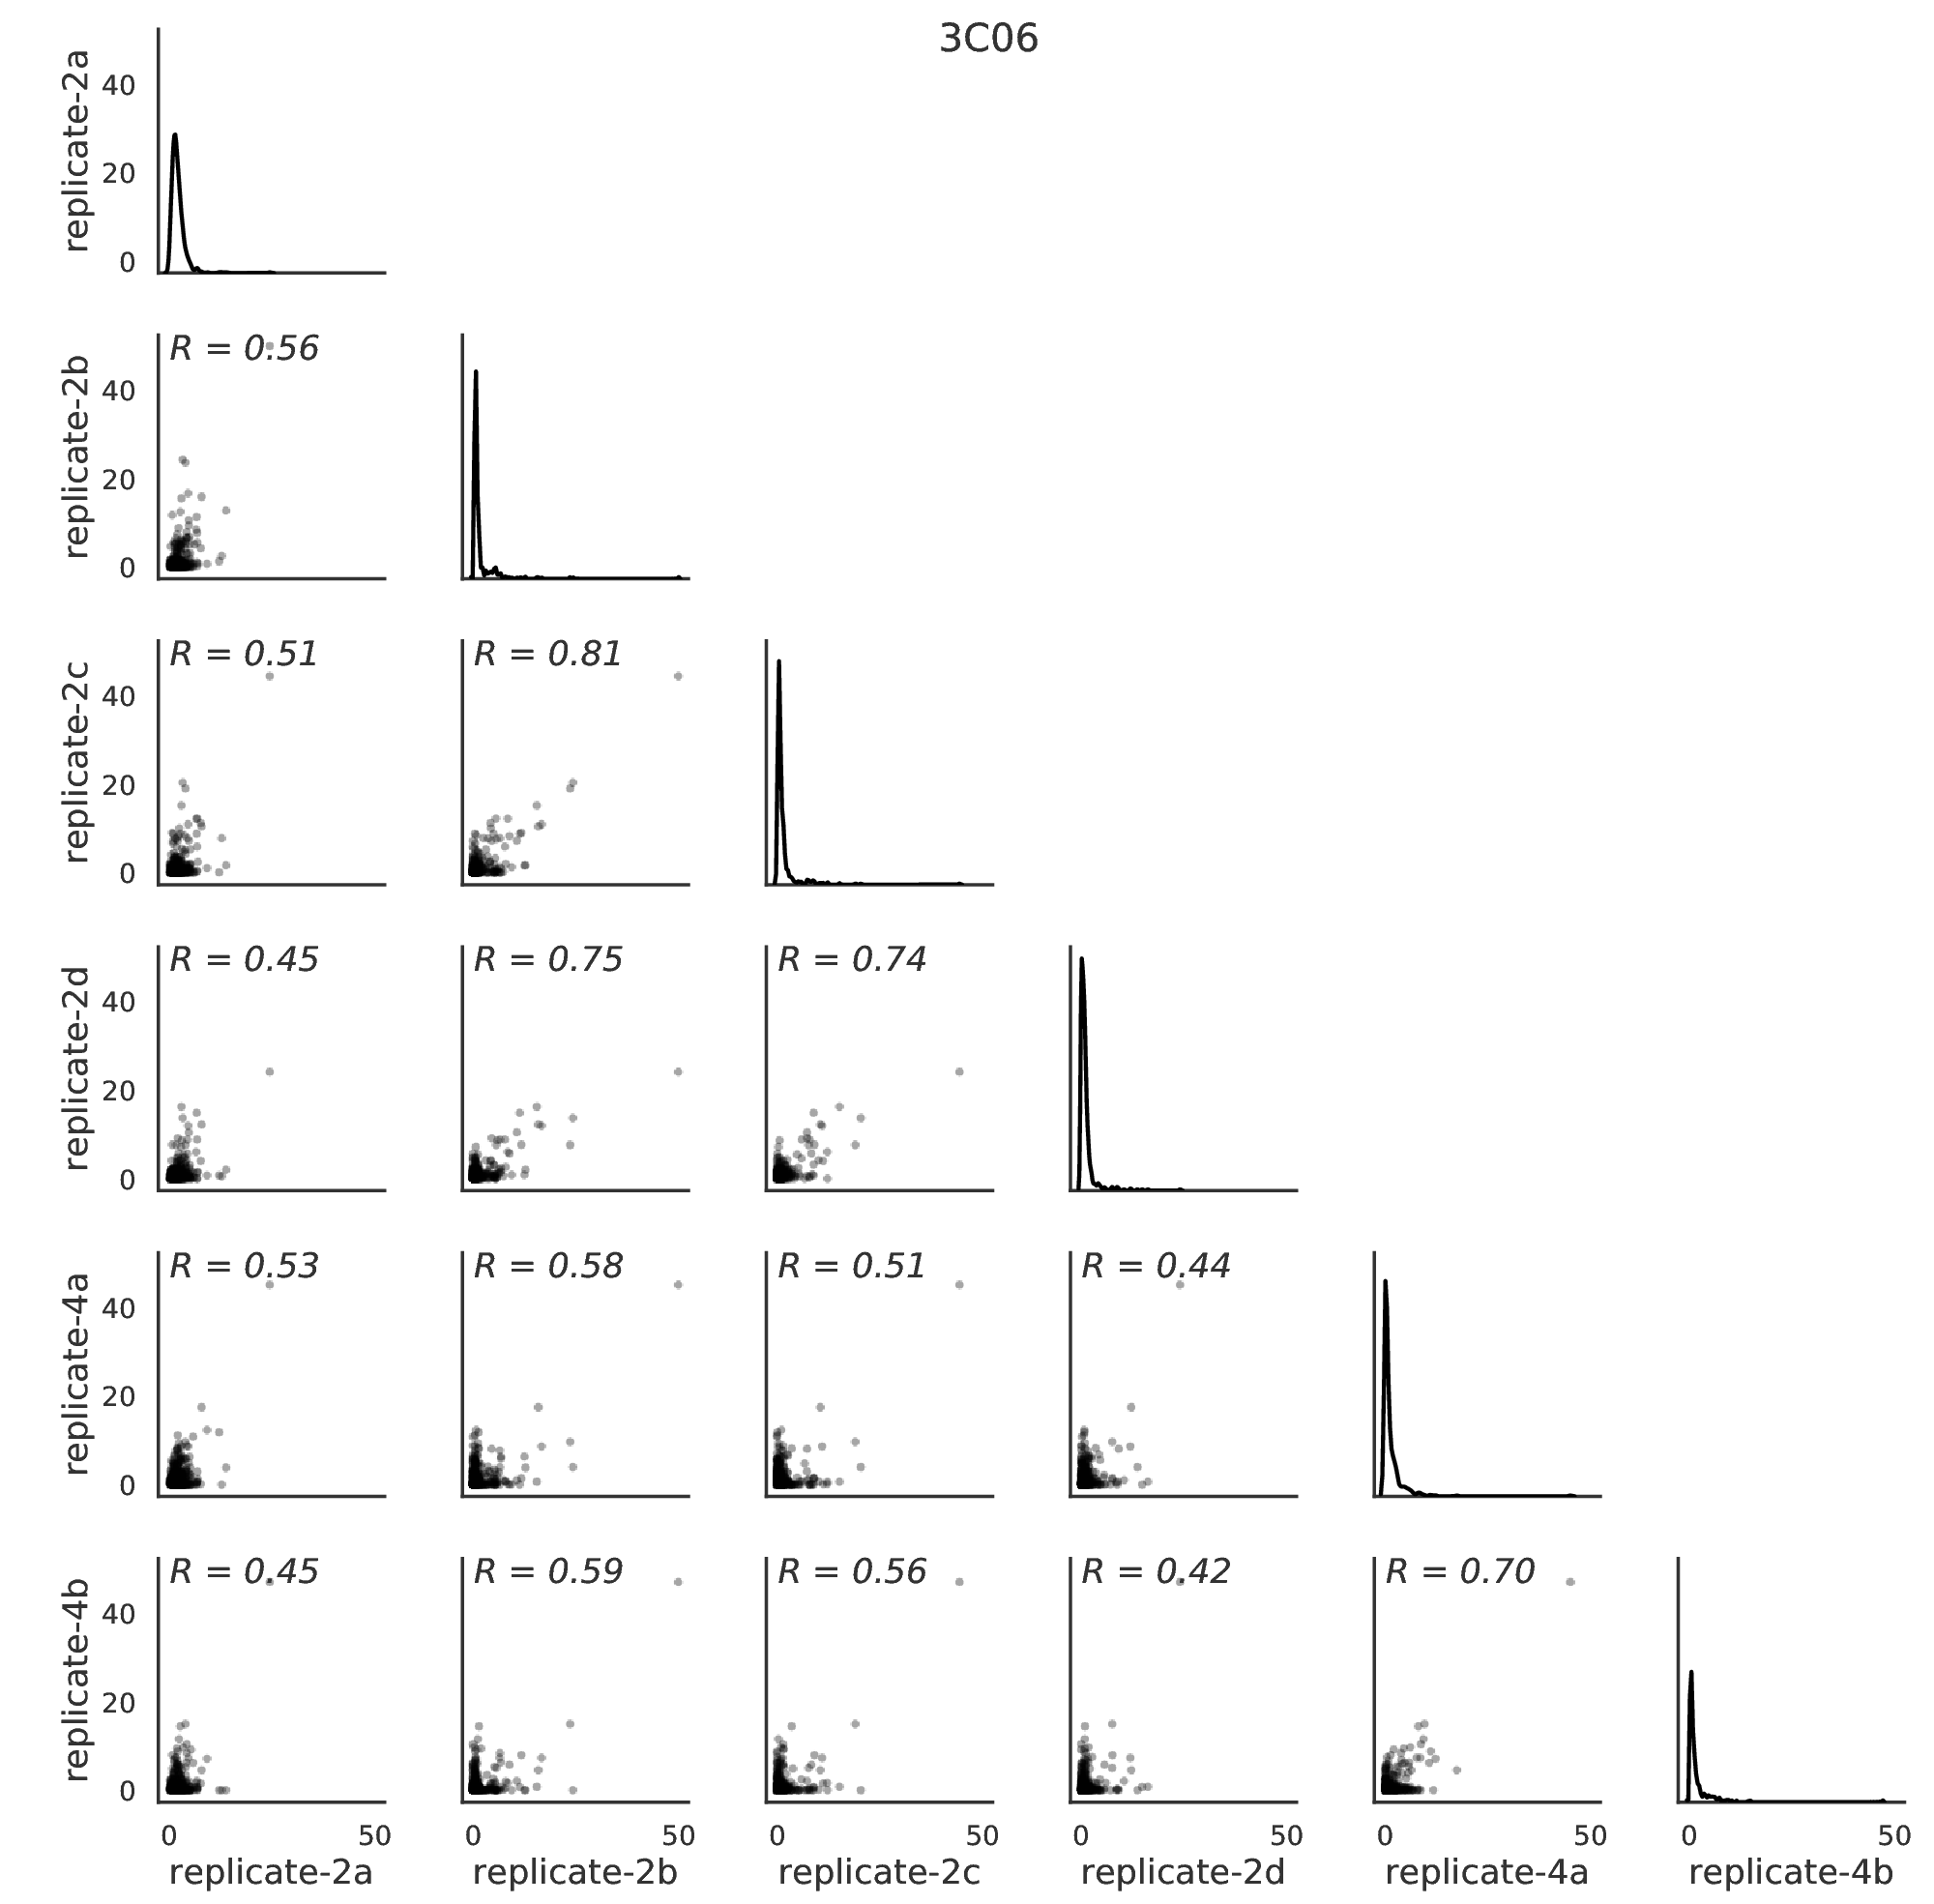


Replicate correlations for 3C04


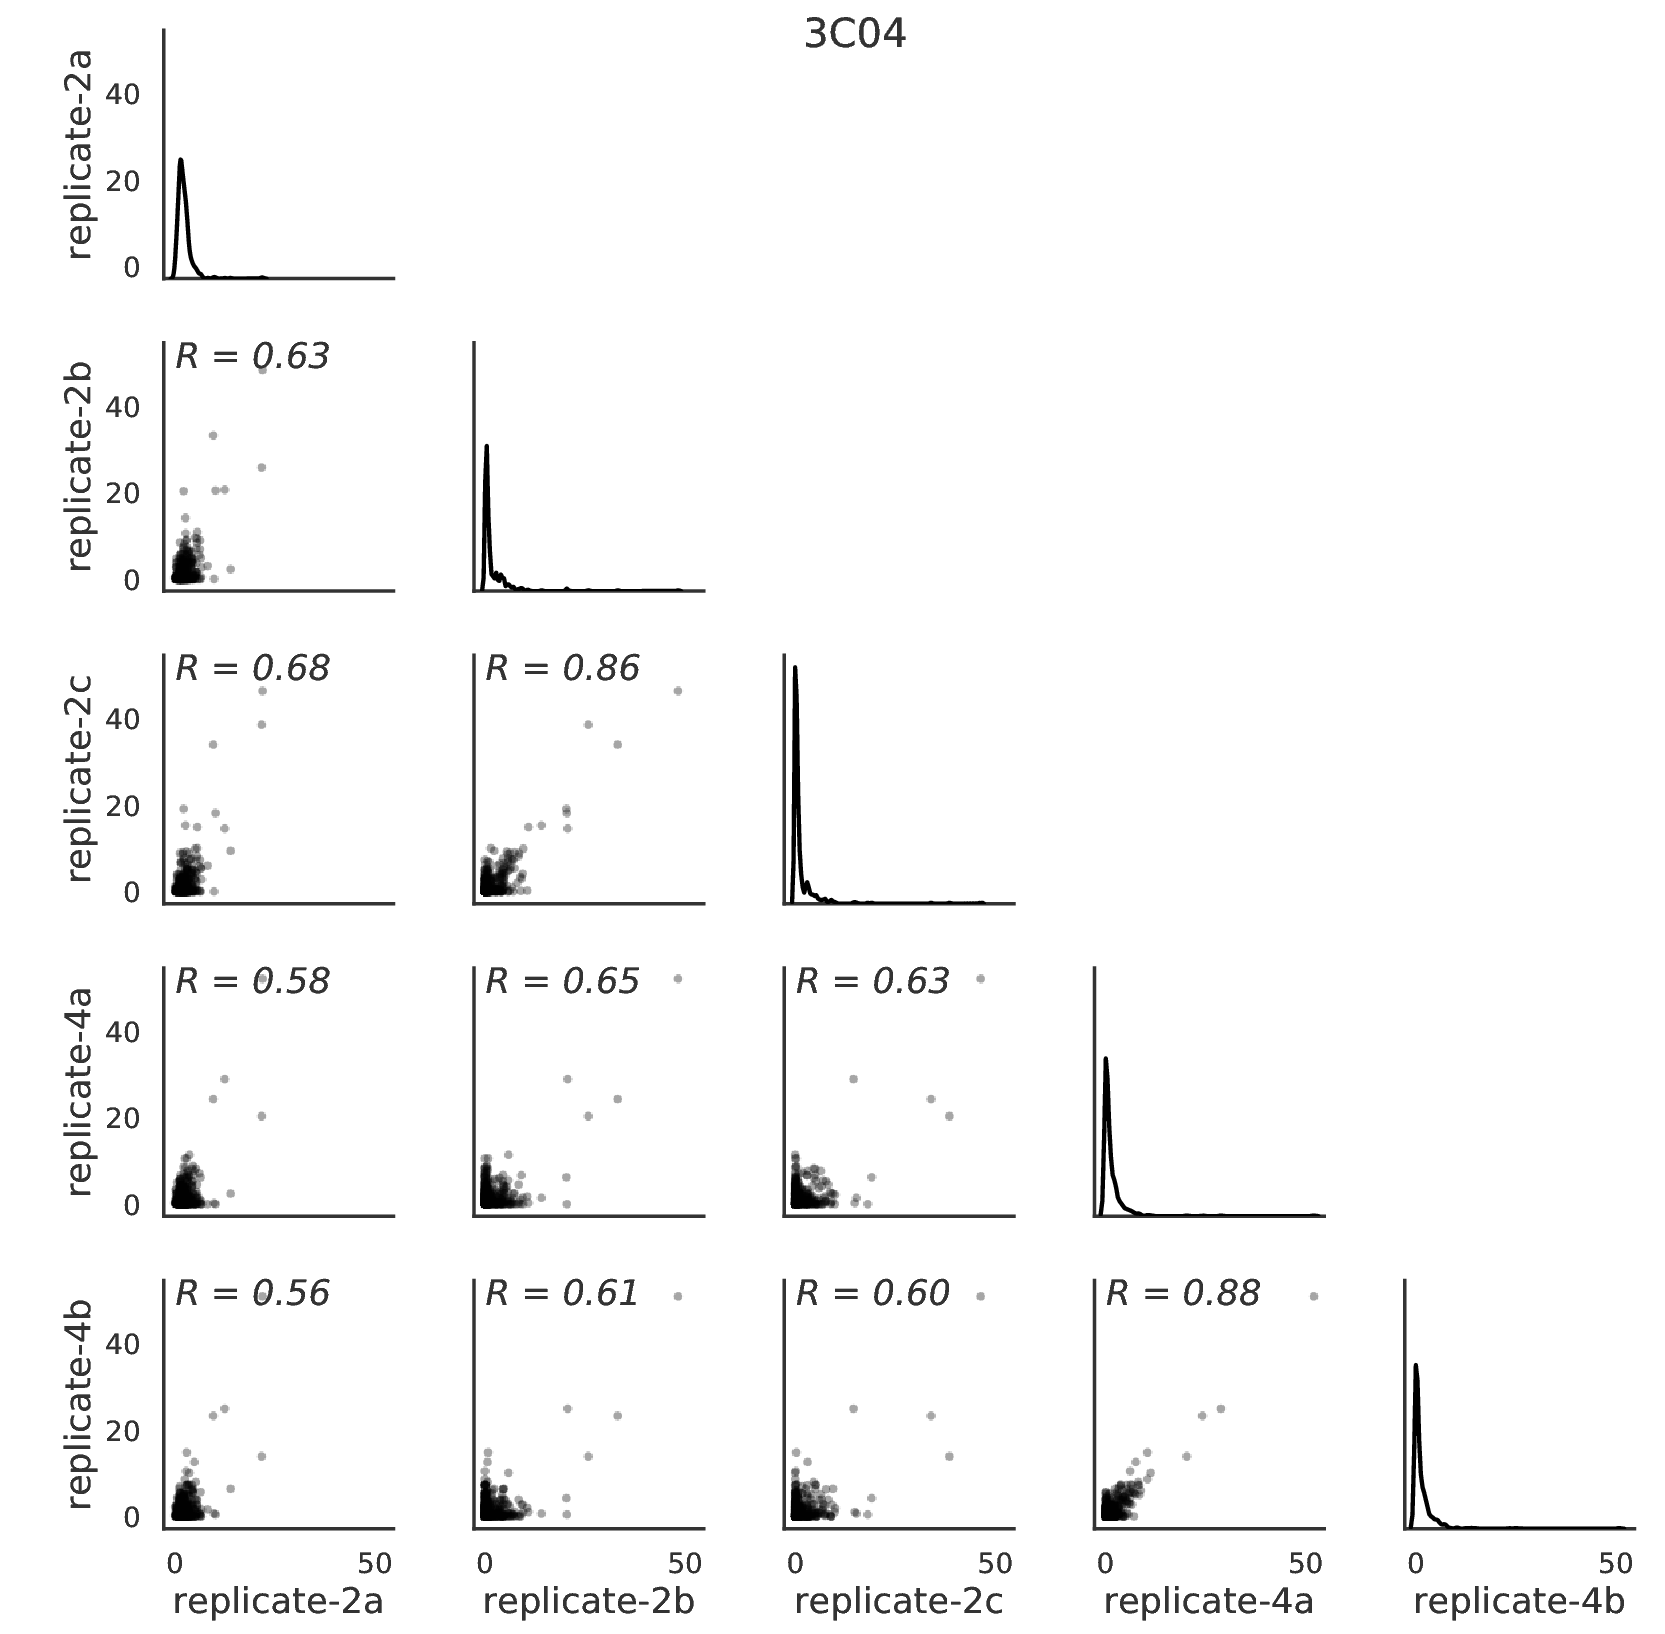

In [24]:
for antibody in diffselbatch['antibody'].unique():
    groups = diffselbatch.query('antibody == @antibody')['group'].unique()
    plots = [diffselprefix + g + '-positivesitediffselcorr.pdf' for g in groups]
    print("\nReplicate correlations for {0}".format(antibody))
    showPDF(plots, width=500 * len(plots))

Now we want to look across the HA sequence to see the positive site differential selection averaged across replicates. When we do so, we see obvious spikes of differential selection, presumably at sites of escape from antibody selection.

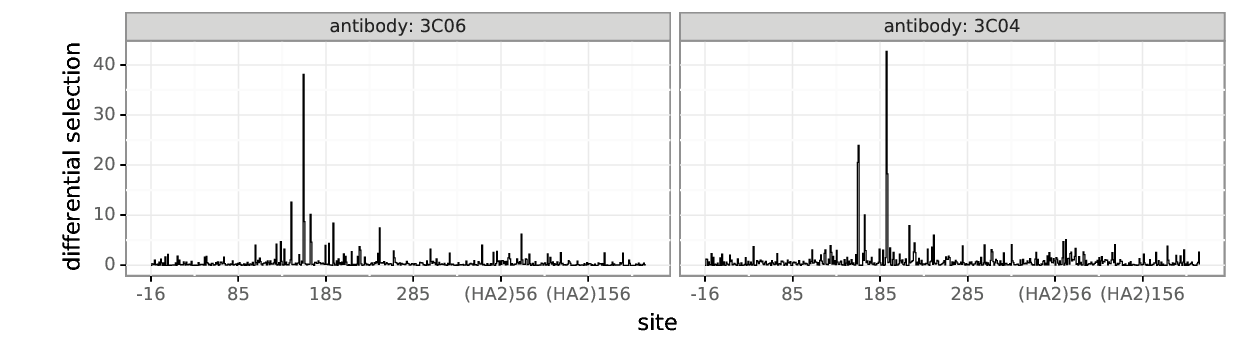

In [25]:
showPDF(diffselprefix + 'meanpositivediffsel.pdf', width=800)

Now we look at the differential selection for the amino-acid mutation with the **maximum** value at each site:

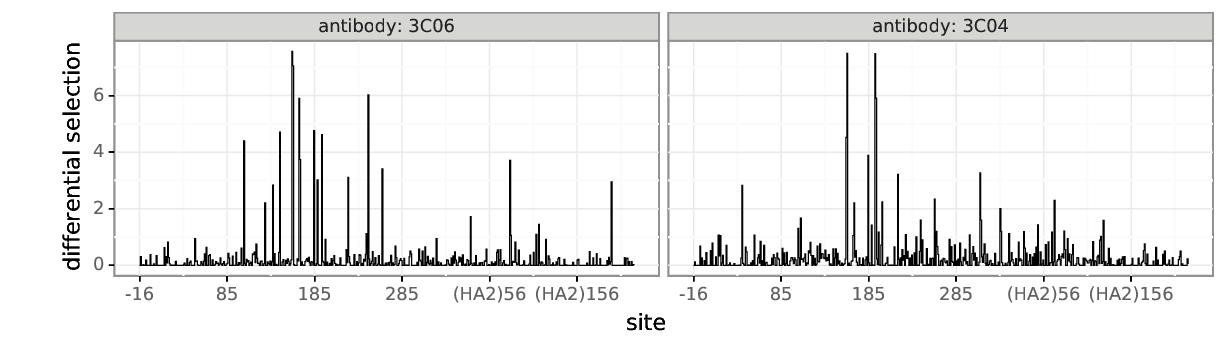

In [26]:
showPDF(diffselprefix + 'medianmaxdiffsel.pdf', width=800)

We will also look at the averaged _negative_ site differential selection for each antibody to see if there are sites at which mutation _increases_ sensitivity to antibody neutralization. However, unlike the large spikes of positive differential selection, we do not see any obvious spikes in negative differential selection.

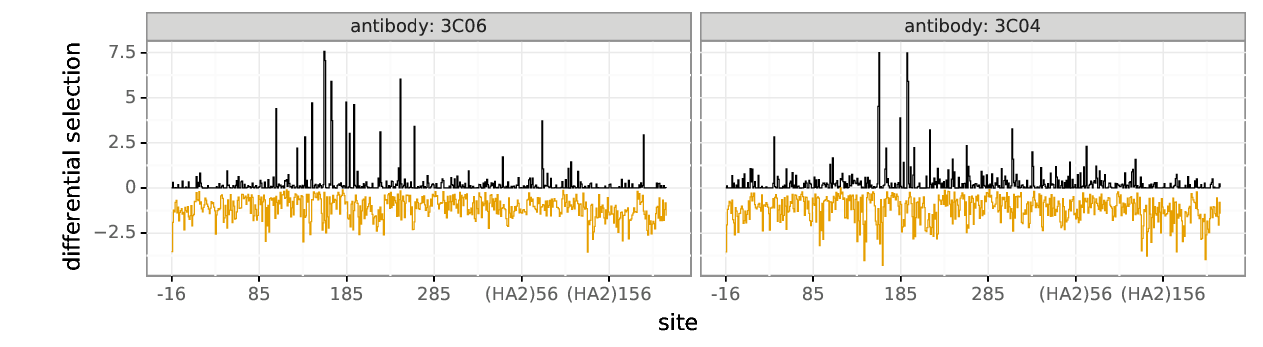

In [27]:
showPDF(diffselprefix + 'medianminmaxdiffsel.pdf', width=800)

Now for each antibody we will take the across-replicate averaged differential selections and use these to make full gene logo plots.


Getting and plotting logo plot for 3C06

Creating logo plot for 3C06 from ./results/differential_selections/summary_3C06-medianmutdiffsel.csv


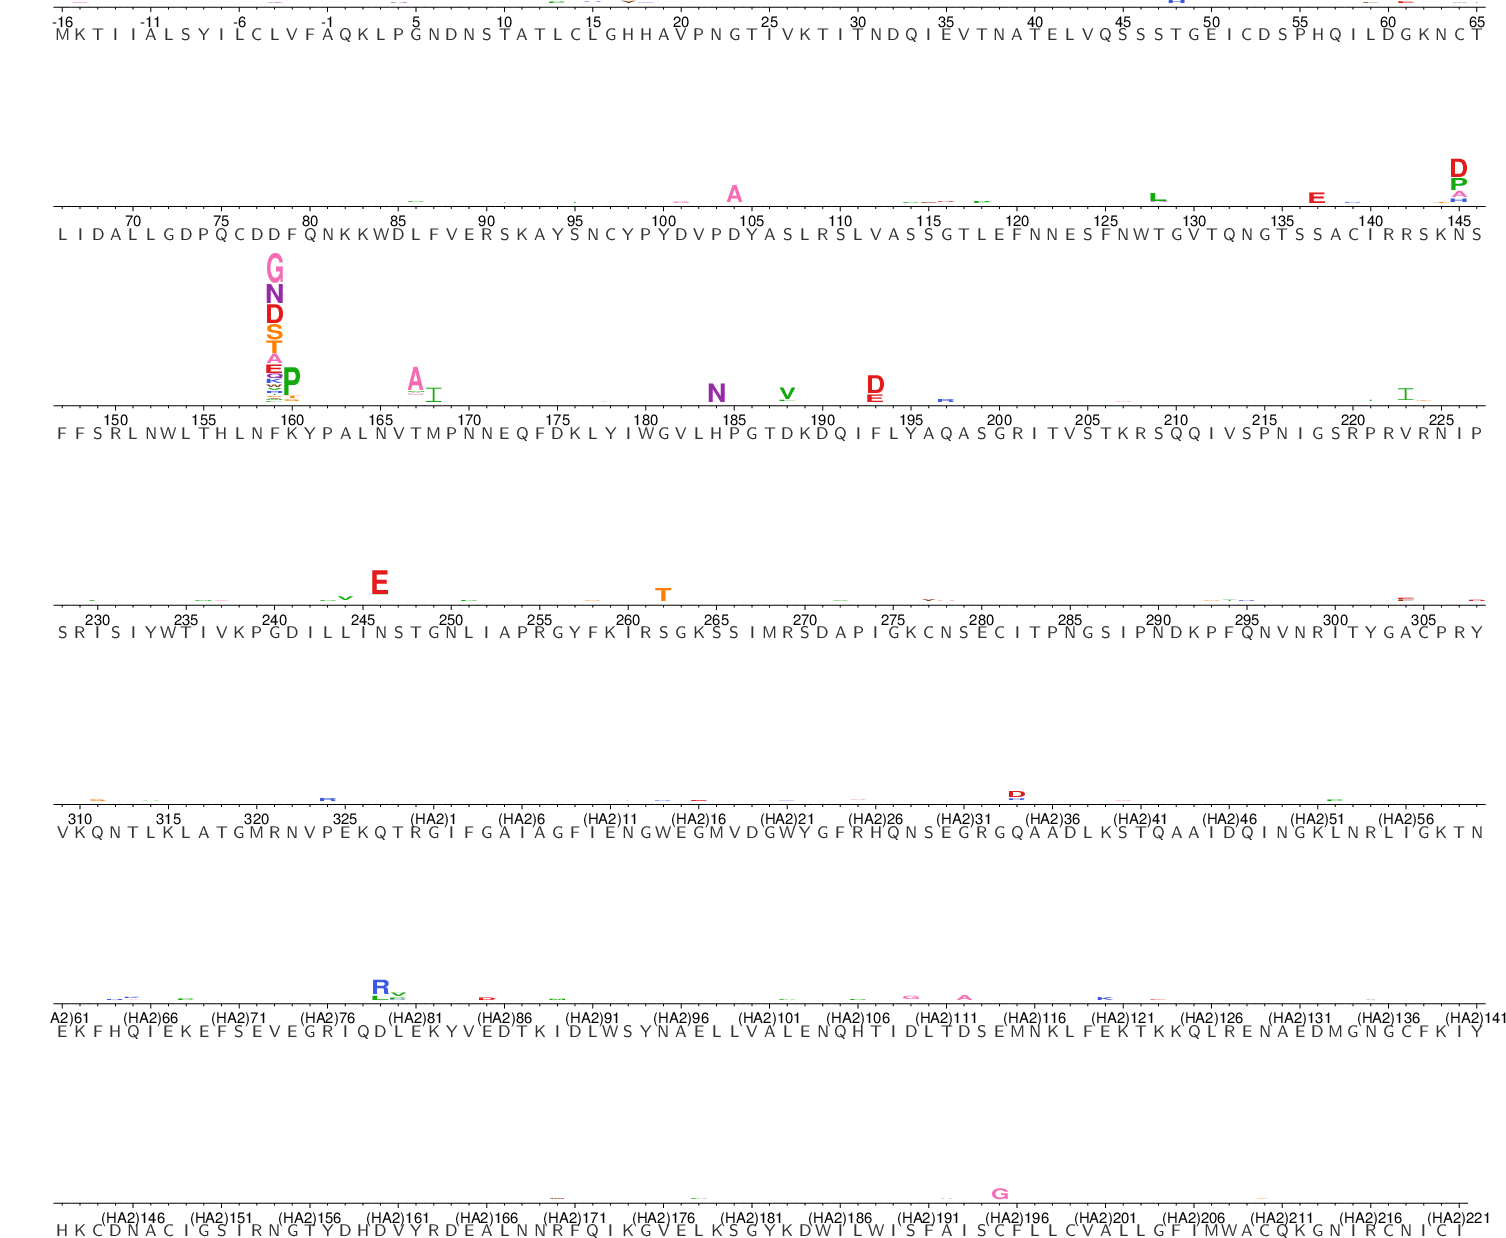


Getting and plotting logo plot for 3C04

Creating logo plot for 3C04 from ./results/differential_selections/summary_3C04-medianmutdiffsel.csv


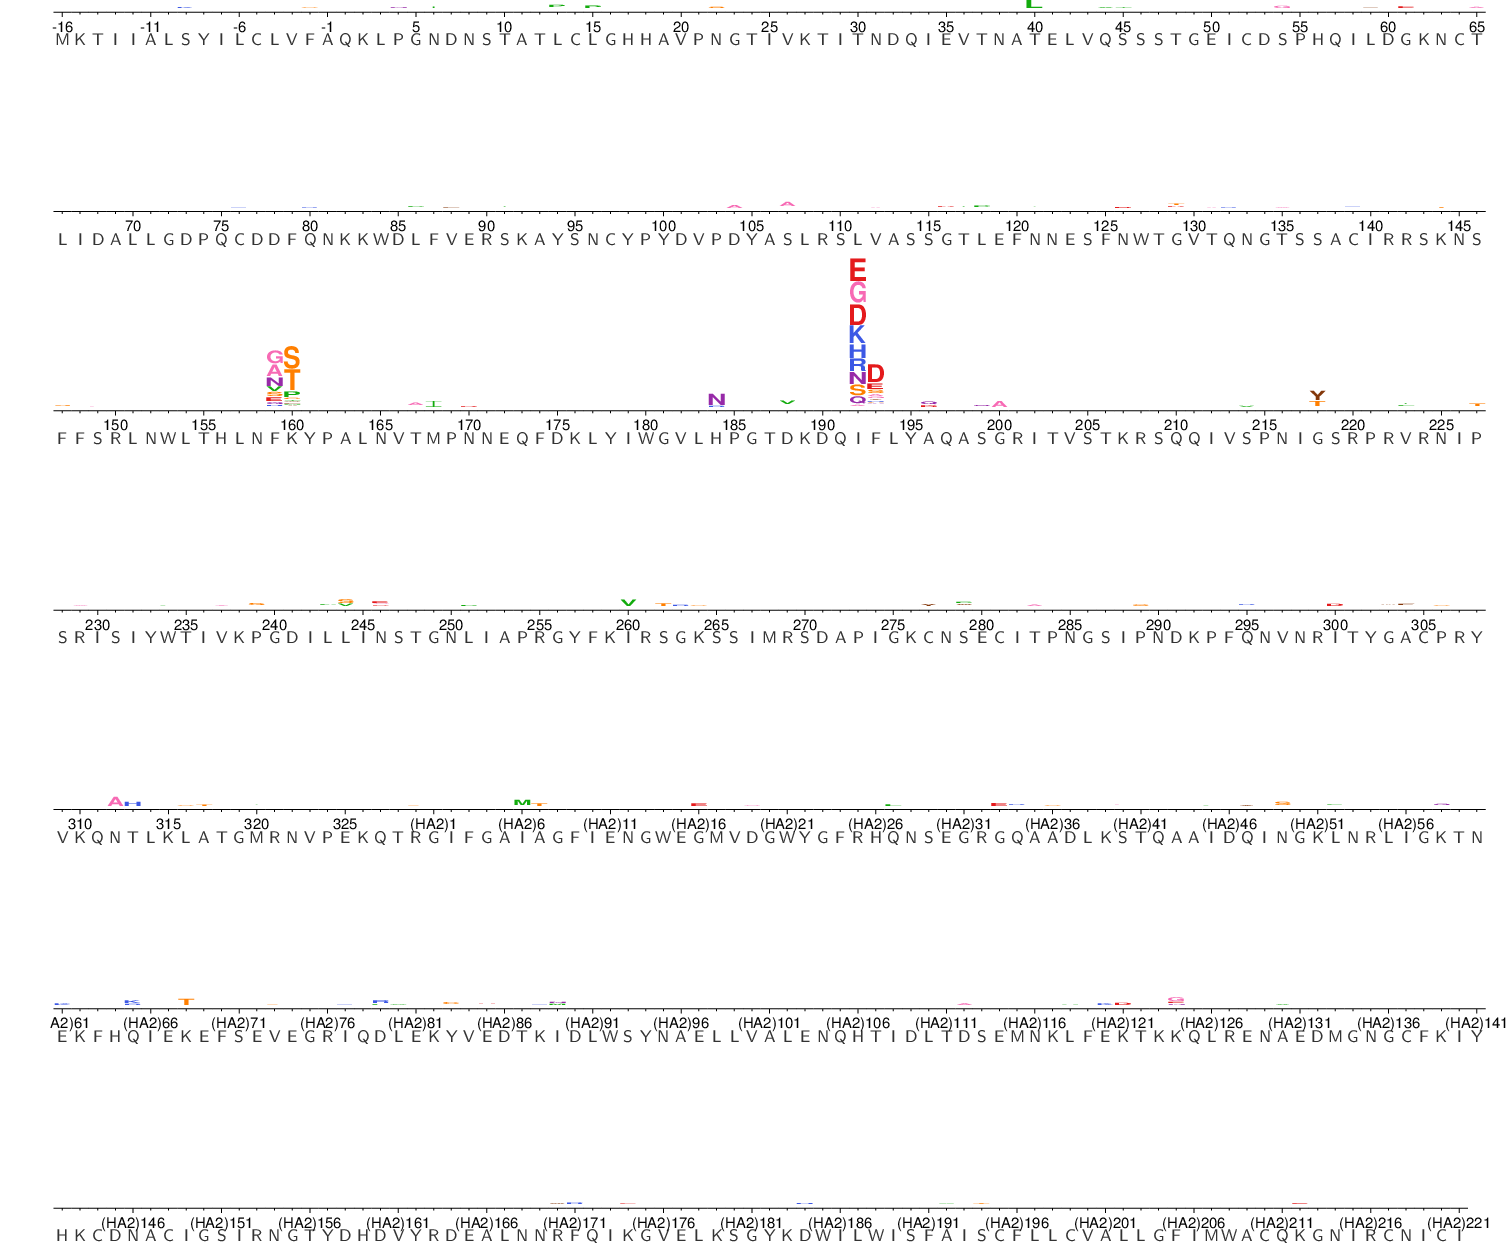

In [28]:
for antibody in diffselbatch['antibody'].unique():
    print ('\nGetting and plotting logo plot for {0}'.format(antibody))
    mutdiffselfile = diffselprefix + antibody + '-medianmutdiffsel.csv'
    
    # now create the logo plot with the overlay
    logoplot = os.path.join(diffseldir, '{0}_diffsel.pdf'.format(antibody))
    print("\nCreating logo plot for {0} from {1}".format(
            antibody, mutdiffselfile))
    log = !dms2_logoplot \
            --diffsel {mutdiffselfile} \
            --name {antibody} \
            --outdir {diffseldir} \
            --restrictdiffsel positive \
            --sepline no \
            --numberevery 5 \
            --nperline 81 \
            --overlay1 {mutdiffselfile} wildtype wildtype \
            --underlay yes \
            --use_existing {use_existing}
    showPDF(logoplot)

The sites of escape for the four site B-targeting antibodies (`5A01`, `3C06`, `3C04`, `4C01`) all map in antigenic site B near the receptor binding site. Interestingly, although all four of these antibodies target the same major antigenic region in H3, we see distinct sites of escape as well as different sets of mutations. Mutation at site 160 to Ser / Thr, which introduces a potential glycan on site 158, seems to a major mode of escape from three of these site B-targeting antibodies.

The sites of escape from `4F03` and `1C04` map lower down in the HA head domain.
The escape profile from `6C05` appears a bit strange; although many of the sites of escape are known antigenic sites, they are scattered across the gene and do not cluster together on the HA structure - possibly a mixture of antibodies from contamination?

## Plot logo plot snippets for sites of interest

We will now create zoomed logo plots for sites of interest.

In [29]:
siteBkeysites = list(range(145, 146)) + list(range(158, 161)) + list(range(192, 194))

# HA sites numbers are strings because some have '(HA2)' headers (e.g., (HA2)100)
siteBkeysites = list(map(str, siteBkeysites))

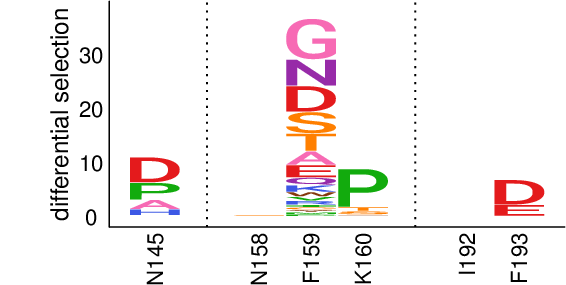

In [30]:
import natsort

names = ['3C06']
diffselfiles = ['./results/differential_selections/summary_3C06-medianmutdiffsel.csv']

mutdiffsels = [] #list of csv files
for mutdiffsel, name in zip(diffselfiles, names): 
    pandadf = pd.read_csv(mutdiffsel)
    # read data frame from tidy CSV format to wide form
    df = dms_tools2.diffsel.tidyToWide(pandadf, valuecol='mutdiffsel')
    
    # only show positive values of mutdiffsel
    df[dms_tools2.AAS] = df[dms_tools2.AAS].clip(lower=0)
    
    #sort sites by 
    df = df.reindex(index=natsort.order_by_index(df.index,natsort.index_natsorted(df.site)))
    
    # add a column indicating what we should show
    df['show'] = df['site'].isin(siteBkeysites)
    
    # want to indicate wildtype along with site number, e.g, C52
    df['site'] = df['wildtype'] + df['site']
    # name of file to plot
    zoomlogoplot_siteB = os.path.join(plotsdir, '{0}_zoomed_diffsel.pdf'.format(name))
    # plot and show
    dms_tools2.rplot.siteSubsetGGSeqLogo(
            logodata=df,
            chars=dms_tools2.AAS,
            plotfile=zoomlogoplot_siteB,
            width=4,
            height=2.5,
            yname='differential selection',
            ylimits=(0,38),
            )
    showPDF(zoomlogoplot_siteB)

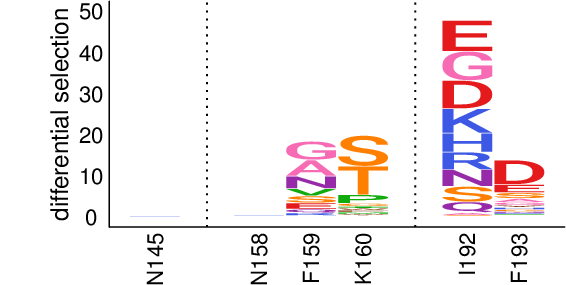

In [31]:
names = ['3C04']
diffselfiles = ['./results/differential_selections/summary_3C04-medianmutdiffsel.csv']

mutdiffsels = [] #list of csv files
for mutdiffsel, name in zip(diffselfiles, names): 
    pandadf = pd.read_csv(mutdiffsel)
    # read data frame from tidy CSV format to wide form
    df = dms_tools2.diffsel.tidyToWide(pandadf, valuecol='mutdiffsel')
    
    # only show positive values of mutdiffsel
    df[dms_tools2.AAS] = df[dms_tools2.AAS].clip(lower=0)
    
    #sort sites by 
    df = df.reindex(index=natsort.order_by_index(df.index,natsort.index_natsorted(df.site)))
    
    # add a column indicating what we should show
    df['show'] = df['site'].isin(siteBkeysites)
    
    # want to indicate wildtype along with site number, e.g, C52
    df['site'] = df['wildtype'] + df['site']
    # name of file to plot
    zoomlogoplot_siteB = os.path.join(plotsdir, '{0}_zoomed_diffsel.pdf'.format(name))
    # plot and show
    dms_tools2.rplot.siteSubsetGGSeqLogo(
            logodata=df,
            chars=dms_tools2.AAS,
            plotfile=zoomlogoplot_siteB,
            width=4,
            height=2.5,
            yname='differential selection',
            ylimits=(0,50),
            )
    showPDF(zoomlogoplot_siteB)